
# Transform zebrafish 3d data for visualisation in Unity
 created 7 Mar 2025, last updated 23 May 2025

 Next todo is to export all brains with their signal data as multiple files to select from in unity

In [72]:

import numpy as np
import h5py
import os
import csv
from scipy.io import loadmat
from scipy.io.matlab._mio5_params import mat_struct
from scipy.signal import find_peaks  # Import find_peaks for peak detection
import pandas as pd
import regex as re
import matplotlib.pyplot as plt

def Extract_Regions_and_Subregions(file):
    try:
        # Load the MATLAB file
        with open(file, 'rb') as f:
            regionData = loadmat(f, struct_as_record=False, squeeze_me=True)
    except Exception as e:
        print(f"Error reading file: {e}")
        return None

    # Extract the 'perRegion' structure
    region_struct = regionData.get('perRegion', None)
    if region_struct is None:
        print("Error: 'perRegion' structure not found in the file.")
        return None

    # Initialize lists to store regions, subregions, and indices
    regions, subregions, indices = [], [], []

    # Iterate through the top-level regions
    for region_name in region_struct._fieldnames:
        if region_name is not None:
            subregion_data = getattr(region_struct, region_name)

            # If subregion_data is a MATLAB struct
            if isinstance(subregion_data, mat_struct):
                for subregion_name in subregion_data._fieldnames:
                    subregion = getattr(subregion_data, subregion_name)
                    regions.append(region_name)
                    subregions.append(subregion_name)

                    # Extract the 'idx' field if it exists
                    if hasattr(subregion, 'idx'):
                        idx_value = subregion.idx
                        if isinstance(idx_value, int):
                            indices.append([idx_value])  # Wrap single int in a list
                        elif isinstance(idx_value, np.ndarray):
                            indices.append(idx_value.tolist())  # Convert NumPy array to list
                        else:
                            indices.append([])  # Fallback for unexpected types
                    else:
                        indices.append([])  # Fallback for missing 'idx'

            # If subregion_data is a NumPy array or list
            elif isinstance(subregion_data, (np.ndarray, list)):
                for subregion in subregion_data:
                    regions.append(region_name)
                    subregions.append(subregion)
                    indices.append([])  # No 'idx' field in this case

            # If subregion_data is a single value
            else:
                regions.append(region_name)
                subregions.append(subregion_data)
                indices.append([])  # No 'idx' field in this case

    # Debugging: Print the extracted data
    print("Extracted regions (sample):", regions[:5])
    print("Extracted subregions (sample):", subregions[:5])
    print("Extracted indices (sample):", indices[:5])
    print(f"Total regions: {len(regions)}, Total subregions: {len(subregions)}, Total indices: {len(indices)}")
    # Return the extracted data as a NumPy array
    return np.array([regions, subregions, indices], dtype=object)

def ExtractPositionData(thisfile):
    print(thisfile)
    try:
        # Open the MATLAB file using h5py
        with h5py.File(thisfile, 'r') as f:
            yxzpos = f.get('fish_ROI_centroids')
            yxzpos = np.array(yxzpos)

        nbrOfCols = yxzpos.shape[1]
        swc_data = []
        for j in range(nbrOfCols):
            SWCIndex = j
            SWCType = 0
            SWCRadius = 1
            SWCParent = 0
            ypos = yxzpos[0, j]
            xpos = yxzpos[1, j]
            zpos = yxzpos[2, j] * 2  # Adjust z position because 2Hz
            swc_data.append([SWCIndex, SWCType, xpos, ypos, zpos, SWCRadius, SWCParent])

        swc_array = np.array(swc_data, dtype=object)
        print(f"Extracted {len(swc_array)} rows from 'fish_ROI_centroids'.")
        return swc_array

    except Exception as e:
        print(f"Error in ExtractPositionData: {e}")
        return None
    # end of ExtractPositionData

def Extract_Signal_Information(thisfile):
    # Open the signals file using h5py
    with h5py.File(thisfile, 'r') as f:
        signals = f.get('fish_stim_trains')
        # Access the object reference
        obj_ref = signals[0, 0]  # Access the first (and only) element
        # Dereference the object
        dereferenced_data = f[obj_ref]
        # Convert the dereferenced data to a trasnposed NumPy array
        data_array = np.array(dereferenced_data).T

    # Create a copy of the data array to modify
    data_with_peaks_only = np.zeros_like(data_array)  # Initialize with zeros

    # Iterate through all rows in the data array
    for row_index in range(data_array.shape[0]):
        row = data_array[row_index, :]  # Extract the row
        peaks, _ = find_peaks(row, height=0.25, distance=50, prominence=0.1)  # Find peaks
        
        data_with_peaks_only[row_index, peaks] = row[peaks]  # Retain only peak values
        
    # Round the peak values to the nearest 0.5
    data_with_peaks_only = np.round(data_with_peaks_only / 0.5) * 0.5
    
    return data_with_peaks_only
    # end of Extract_Signal_Information

def MashEmTogether(fishData, regionsData, sigsData):
    wrongix = []  # To track invalid indices

    # Iterate through regions and their corresponding indices
    for region, idx_list, subregion in zip(regionsData[0], regionsData[2], regionsData[1]):
        if idx_list is not None:
            for idx in idx_list:
                # Adjust MATLAB 1-based index to Python 0-based index
                adjusted_idx = idx - 1

                # Ensure the index is valid and within bounds
                if isinstance(adjusted_idx, int) and 0 <= adjusted_idx < fishData.shape[0]:
                    # Append the region to the corresponding row in fishData
                    if region not in fishData[adjusted_idx, 7]:  # Ensure no duplicates
                        fishData[adjusted_idx, 7].append(region)  # Add to the 'Region' column
                    # Append the subregion to the corresponding row in fishData
                    if subregion not in fishData[adjusted_idx, 8]:  # Ensure no duplicates
                        fishData[adjusted_idx, 8].append(subregion)  # Add to the 'Subregion' column
                else:
                    # Track invalid indices
                    wrongix.append(idx)

    # Debugging: Print invalid indices if any
    if wrongix:
        print("In case you need to troubleshoot, these are the wrong indices:", set(wrongix))

    # Sort regions and assign the first region as the SWC Parent
    sortOrder = ['Diencephalon', 'Telencephalon', 'Mesencephalon', 'Rhombencephalon', 'Ganglia', 'Spinal']
    for row in fishData:
        # Sort regions based on the predefined order
        row[7] = sorted(row[7], key=lambda x: sortOrder.index(x) if x in sortOrder else len(sortOrder))
        
        # Assign the first region as the SWC Parent
        row[6] = row[7][0] if row[7] else None  # Use the first region from the sorted list

        # Join regions with ' + ' for display purposes
        row[7] = ' + '.join(row[7])

        # Clean up subregion text
        cleaned_subregions = [
            re.sub(r"^r_?['\"]?|['\"]$", "", subregion.strip("[]'")) for subregion in row[8]
        ]
        # Filter out empty subregions or subregions that are just "_r"
        cleaned_subregions = [subregion for subregion in cleaned_subregions if subregion]

        # Add separator if more than 1 subregion
        if len(cleaned_subregions) > 1:
            cleaned_subregions = ' + '.join(cleaned_subregions)
        else:
            cleaned_subregions = cleaned_subregions[0] if cleaned_subregions else None
        row[8] = cleaned_subregions

        # Generate HTML for the Label column
        region_html = row[7] if row[7] else 'None'
        subregion_html = cleaned_subregions if cleaned_subregions else 'None'
        row[9] = f"<b>Regions:</b> {region_html}<br><b>Subregions:</b> {subregion_html}"

    # Merge signal data into fishData
    if sigsData is not None and sigsData.shape[0] == fishData.shape[0]:
        fishData = np.hstack((fishData, sigsData))  # Append signal data as new columns
    else:
        print("Warning: Signal data does not match the number of rows in fishData. Skipping merge.")
        print("nbr rows in fishData:", fishData.shape[0])
        print("nbr rows in sigsData:", sigsData.shape[0])

    return fishData # end of mashEmTogether


# Main script
csv_dir = "Assets/Data/" # eg ZF.FishSignalData68.csv would be saved in this directory
regs_dir= "Calcium data/region_roi_information/" # eg regioninfo_07.mat
WTsigs_dir = "Calcium data/WT/" # eg raw_fish_std_fmt_07.mat
HOMsigs_dir = "Calcium data/HOM/" # eg raw_fish_std_fmt_01.mat

# get all fish IDs from the regions directory
regFiles = [f for f in os.listdir(regs_dir) if f.endswith('.mat')]
fishNbrs = []
for f in regFiles:
    fishNbrs.append(f.split("_")[1].split(".")[0])  # Add to list of fish number from the filename

WtFiles = [os.path.join(WTsigs_dir, f) for f in os.listdir(WTsigs_dir) if f.endswith('.mat')]
HomFiles = [os.path.join(HOMsigs_dir, f) for f in os.listdir(HOMsigs_dir) if f.endswith('.mat')]
sigsFiles = WtFiles + HomFiles
print(sigsFiles)

for fishID in fishNbrs:
    # Construct file names
    print(f"Processing fish ID: {fishID}")
    csv_filename = os.path.join(csv_dir, f"ZF.FishSignalData{fishID}.csv")
    regsfile = os.path.join(regs_dir, f"regioninfo_{fishID}.mat")
    sigsfile = [f for f in sigsFiles if fishID in f][0] # Find the corresponding signal file
    print(sigsfile)

    fishData = ExtractPositionData(sigsfile)

    # Initialize fishData with additional columns for Region, Subregion, and Label
    fishData = np.hstack((fishData, np.empty((fishData.shape[0], 3), dtype=object)))
    fishData[:, 7] = [[] for _ in range(fishData.shape[0])]  # Region
    fishData[:, 8] = [[] for _ in range(fishData.shape[0])]  # Subregion
    fishData[:, 9] = ""  # Label

    # Extract regions and subregions
    regionsData = Extract_Regions_and_Subregions(regsfile)

    # extract signal information
    signalData = Extract_Signal_Information(sigsfile)

    # Mash the data together
    fishData = MashEmTogether(fishData, regionsData,signalData)

    # Save to CSV
    header = '# SWC Index,SWC Type,xpos,ypos,zpos,radius,SWC Parent,Region,Subregion,Label'
    np.savetxt(
        csv_filename,
        fishData,
        delimiter=',',
        fmt='%s',
        header=header,
        comments=''  # Remove the default '#' added by np.savetxt
    )
    # close regions file

    # close signals file
    print(f"Data saved to {csv_filename}")
# end of loop through fish IDs

['Calcium data/WT/raw_fish_std_fmt_63.mat', 'Calcium data/WT/raw_fish_std_fmt_58.mat', 'Calcium data/WT/raw_fish_std_fmt_59.mat', 'Calcium data/WT/raw_fish_std_fmt_17.mat', 'Calcium data/WT/raw_fish_std_fmt_14.mat', 'Calcium data/WT/raw_fish_std_fmt_07.mat', 'Calcium data/WT/raw_fish_std_fmt_37.mat', 'Calcium data/WT/raw_fish_std_fmt_20.mat', 'Calcium data/WT/raw_fish_std_fmt_35.mat', 'Calcium data/WT/raw_fish_std_fmt_19.mat', 'Calcium data/WT/raw_fish_std_fmt_25.mat', 'Calcium data/WT/raw_fish_std_fmt_24.mat', 'Calcium data/WT/raw_fish_std_fmt_32.mat', 'Calcium data/WT/raw_fish_std_fmt_27.mat', 'Calcium data/WT/raw_fish_std_fmt_42.mat', 'Calcium data/WT/raw_fish_std_fmt_52.mat', 'Calcium data/WT/raw_fish_std_fmt_53.mat', 'Calcium data/HOM/raw_fish_std_fmt_61.mat', 'Calcium data/HOM/raw_fish_std_fmt_60.mat', 'Calcium data/HOM/raw_fish_std_fmt_62.mat', 'Calcium data/HOM/raw_fish_std_fmt_67.mat', 'Calcium data/HOM/raw_fish_std_fmt_66.mat', 'Calcium data/HOM/raw_fish_std_fmt_64.mat', 'Cal

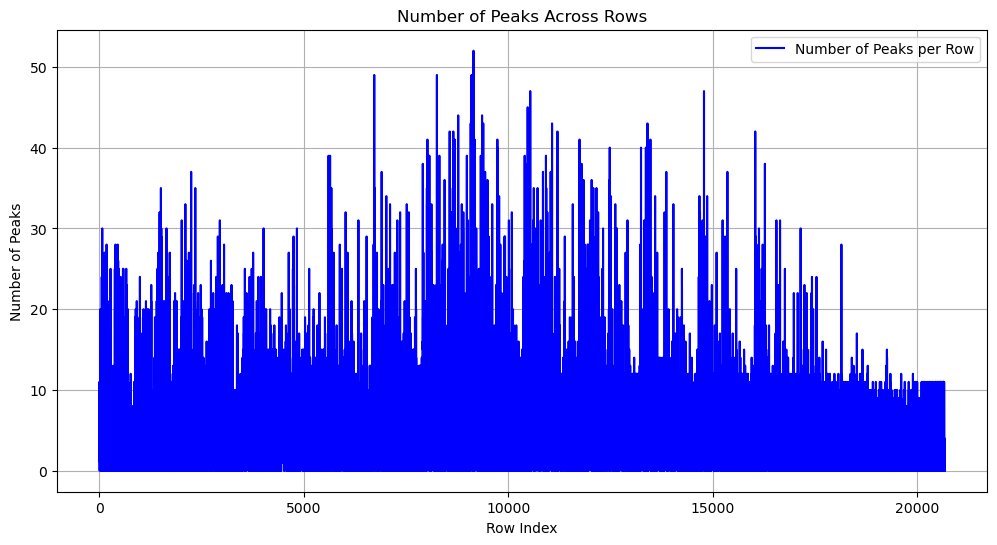

In [73]:
# extract signal information
signalData = Extract_Signal_Information(sigsfile)

# Initialize a list to store the number of peaks for each row
num_peaks_per_row = []

# Iterate through all rows in the data array
for row_index in range(signalData.shape[0]):
    row = signalData[row_index, :]  # Extract the row
    peaks, _ = find_peaks(row, height=0.25, distance=50, prominence=0.1)  # Find peaks
    num_peaks_per_row.append(len(peaks))  # Store the number of peaks

# Plot the number of peaks across all rows
plt.figure(figsize=(12, 6))
plt.plot(num_peaks_per_row, label="Number of Peaks per Row", color='blue')
plt.title("Number of Peaks Across Rows")
plt.xlabel("Row Index")
plt.ylabel("Number of Peaks")
plt.legend()
plt.grid(True)
plt.show()

In [74]:
thisfile = "Calcium data/WT/raw_fish_std_fmt_07.mat"

# Open the signals file using h5py
with h5py.File(thisfile, 'r') as f:
    signals = f.get('fish_stim_trains')

    # Check if the data exists and is valid
    if signals is None:
        raise ValueError("The 'fish_stim_trains' dataset is missing in the file.")

    print("Type of 'fish_stim_trains':", type(signals))
    print("Shape of 'fish_stim_trains':", signals.shape)
    print("Size of 'fish_stim_trains':", signals.size)

    # Access the object reference
    obj_ref = signals[0, 0]  # Access the first (and only) element
    print("Object reference:", obj_ref)

    # Dereference the object
    dereferenced_data = f[obj_ref]
    print("Dereferenced data type:", type(dereferenced_data))
    print("Dereferenced data shape:", dereferenced_data.shape)

    # Convert the dereferenced data to a NumPy array
    data_array = np.array(dereferenced_data)

    # Flatten the array to find the highest values across all rows and columns
    flattened_data = data_array.flatten()

    # Get the indices of the 10 highest values
    top_10_indices = np.argsort(flattened_data)[-10:]  # Indices of the top 10 values
    top_10_values = flattened_data[top_10_indices]    # The top 10 values themselves
    # Get the indices of the 10 lowest values
    bottom_10_indices = np.argsort(flattened_data)[:10]  # Indices of the bottom 10 values
    bottom_10_values = flattened_data[bottom_10_indices]  # The bottom 10 values themselves

    # Print the results
    print("Top 10 values:", top_10_values)
    print("Bottom 10 values:", bottom_10_values)

    # Count the number of values greater than max threshold
max_thresh = 1.25
above_max_threshold = np.sum(data_array > max_thresh)

# Print the result
print("Number of values above max threshold:", above_max_threshold)    

# Count the number of values below than min threshold
min_thresh = -0.075
below_min_threshold = np.sum(data_array < min_thresh)

# Print the result
print("Number of values below min threshold:", below_min_threshold)
      

Type of 'fish_stim_trains': <class 'h5py._hl.dataset.Dataset'>
Shape of 'fish_stim_trains': (1, 1)
Size of 'fish_stim_trains': 1
Object reference: <HDF5 object reference>
Dereferenced data type: <class 'h5py._hl.dataset.Dataset'>
Dereferenced data shape: (4200, 17790)
Top 10 values: [1.9614042  1.97055173 1.97279167 1.97926879 1.98707068 2.01701045
 2.04643798 2.06966066 2.20135236 2.34884524]
Bottom 10 values: [-0.17541517 -0.16101228 -0.14070615 -0.1406745  -0.13786633 -0.13769755
 -0.13535859 -0.13389263 -0.13008468 -0.12931913]
Number of values above max threshold: 609
Number of values below min threshold: 1256


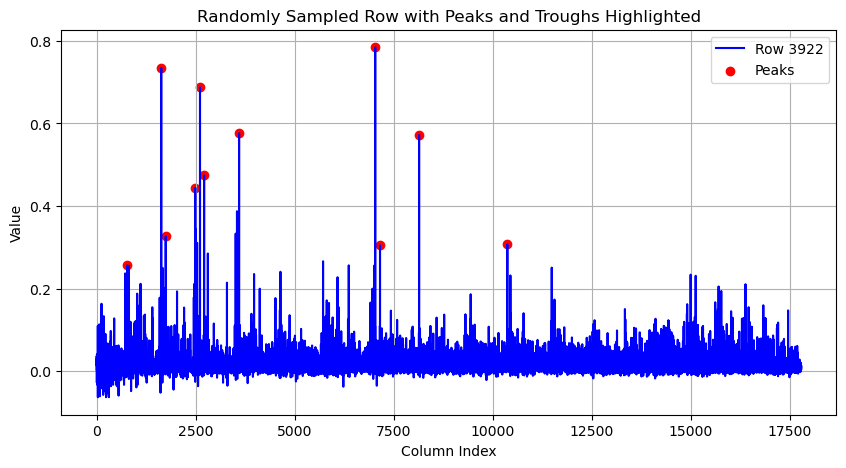

In [75]:
import matplotlib.pyplot as plt  # Import matplotlib for plotting
import random  # Import random for selecting a random row



thisfile = "Calcium data/WT/raw_fish_std_fmt_07.mat"

# Open the signals file using h5py
with h5py.File(thisfile, 'r') as f:
    signals = f.get('fish_stim_trains')
    # Access the object reference
    obj_ref = signals[0, 0]  # Access the first (and only) element
    # Dereference the object
    dereferenced_data = f[obj_ref]
    # Convert the dereferenced data to a NumPy array
    data_array = np.array(dereferenced_data)


# Randomly sample a row from the data array
random_row_index = random.randint(0, data_array.shape[0] - 1)  # Random row index
random_row = data_array[random_row_index, :]  # Extract the random row

# Find the peaks in the random row
peaks, _ = find_peaks(random_row, height=0.25, distance=100, prominence=0.3)
# height detects peaks with a value greater than .25
# distance between peaks to reduce closely spaced peaks
# promimnence is peaks that stand out by at least .4 relative to their neighbors


# Plot the random row as a line chart
plt.figure(figsize=(10, 5))
plt.plot(random_row, label=f"Row {random_row_index}", color='blue')  # Plot the line
plt.scatter(peaks, random_row[peaks], color='red', label='Peaks')  # Highlight peaks in red
plt.title("Randomly Sampled Row with Peaks and Troughs Highlighted")
plt.xlabel("Column Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

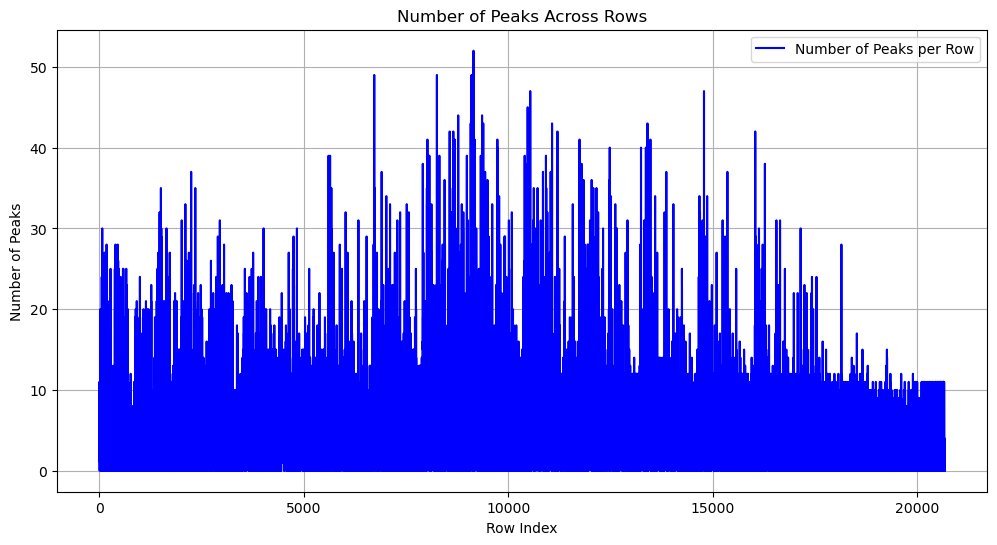

In [76]:
data_array = signalData

# Initialize a list to store the number of peaks for each row
num_peaks_per_row = []

# Iterate through all rows in the data array
for row_index in range(data_array.shape[0]):
    row = data_array[row_index, :]  # Extract the row
    peaks, _ = find_peaks(row, height=0.25, distance=50, prominence=0.1)  # Find peaks
    num_peaks_per_row.append(len(peaks))  # Store the number of peaks

# Plot the number of peaks across all rows
plt.figure(figsize=(12, 6))
plt.plot(num_peaks_per_row, label="Number of Peaks per Row", color='blue')
plt.title("Number of Peaks Across Rows")
plt.xlabel("Row Index")
plt.ylabel("Number of Peaks")
plt.legend()
plt.grid(True)
plt.show()

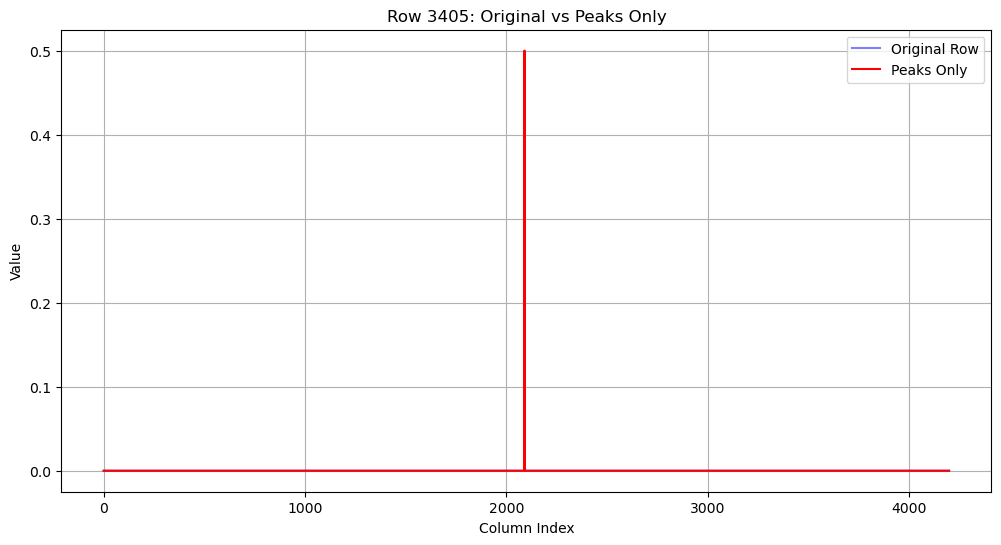

In [77]:
# Create a copy of the data array to modify
data_with_peaks_only = np.zeros_like(data_array)  # Initialize with zeros

# Iterate through all rows in the data array
for row_index in range(data_array.shape[0]):
    row = data_array[row_index, :]  # Extract the row
    peaks, _ = find_peaks(row, height=0.25, distance=50, prominence=0.1)  # Find peaks
    data_with_peaks_only[row_index, peaks] = row[peaks]  # Retain only peak values

# Plot an example row to verify the result
random_row_index = random.randint(0, data_with_peaks_only.shape[0] - 1)
plt.figure(figsize=(12, 6))
plt.plot(data_array[random_row_index, :], label="Original Row", color='blue', alpha=0.5)
plt.plot(data_with_peaks_only[random_row_index, :], label="Peaks Only", color='red')
plt.title(f"Row {random_row_index}: Original vs Peaks Only")
plt.xlabel("Column Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

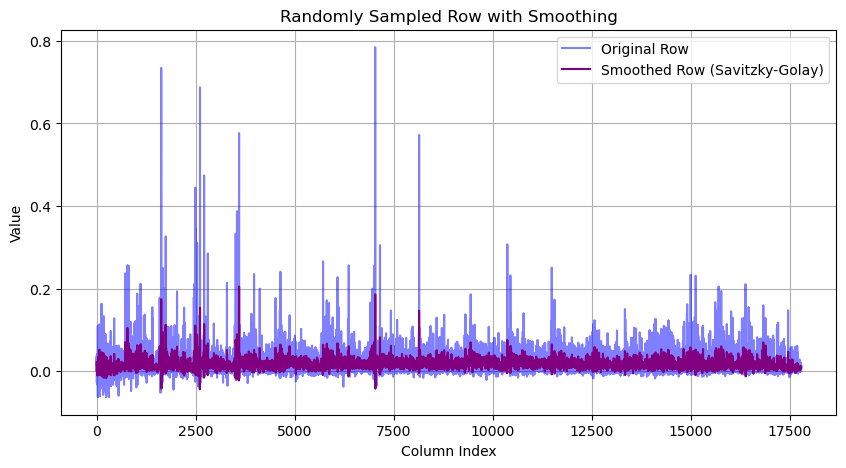

In [78]:
from scipy.signal import savgol_filter

# Smooth the random row using a Savitzky-Golay filter
smoothed_row = savgol_filter(random_row, window_length=11, polyorder=2)

# Plot the smoothed row
plt.figure(figsize=(10, 5))
plt.plot(random_row, label="Original Row", color='blue', alpha=0.5)  # Original data
plt.plot(smoothed_row, label="Smoothed Row (Savitzky-Golay)", color='purple')  # Smoothed data
plt.title("Randomly Sampled Row with Smoothing")
plt.xlabel("Column Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()